<h2> Marketing Analytics - Teste A/B para avaliar aumento de vendas de produtos online<br/><br/>
Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online?</h2>

<h4> Neste projeto, vamos seguir 5 passos para análise de um teste A/B<br/><br/> </h4>
1. Configurar o experimento <br/><br/>
2. Executar o teste de hipóteses e registr a taxa de sucesso de cada grupo<br/><br/>
3. Criamos o Plot da distribuição da diferença entre as duas amostras <br/><br/>
4. Calculamos o poder estatístico<br/><br/>
5. Avaliamos como o tamanho das amostras afeta os Testes A/B

In [13]:
# Importando as bibliotecas

import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs

In [3]:
# Carregando a base de dados
df_vendas = pd.read_csv("MarketingAnalytics.csv")

In [5]:
# Analisando os primeiros dados do dataset
df_vendas.head()

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


## Análise Exploratória e Cálculo de Probabilidade

In [8]:
# Tipo dos dados
df_vendas.dtypes

id          object
variante    object
compra        bool
data        object
dtype: object

In [9]:
# Data mínima
df_vendas['data'].min()

'2019-01-01'

In [10]:
# Data máxima
df_vendas['data'].max()

'2020-01-30'

In [11]:
# Verificando se há valores nulos (Limpeza dos dados)
df_vendas.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [12]:
# Verificando se há valores duplicados
df_vendas.id.value_counts().count()

55000

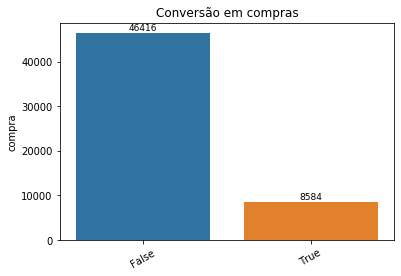

In [29]:
# Conversão de visualizações em compras
df_vendas['compra'].value_counts()
compras = sns.barplot(x=df_vendas['compra'].value_counts().index, y=df_vendas['compra'].value_counts())
compras.set_title('Conversão em compras')
compras.set_xticklabels(compras.get_xticklabels(), rotation=30)
for p in compras.patches:
             compras.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                 textcoords='offset points')


([<matplotlib.patches.Wedge at 0x139dc069108>,
 [Text(-0.9704020090916421, 0.5179960817910738, 'False'),
  Text(0.9704019848424945, -0.5179961272188695, 'True')],
 [Text(-0.5293101867772593, 0.2825433173405857, '84%'),
  Text(0.5293101735504515, -0.2825433421193833, '16%')])

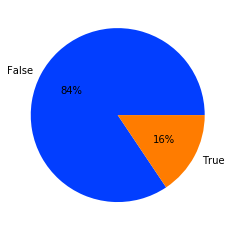

In [36]:
# Proporção das variantes mostradas aos usuários
plt.pie(df_vendas['compra'].value_counts(), labels = df_vendas['compra'].value_counts().index, colors = sns.color_palette('bright')[0:5], autopct='%.0f%%')

In [37]:
# Probabilidade de um usuário visualizar a variante A
df_vendas[df_vendas.variante == 'A'].shape[0] / df_vendas.shape[0] * 100

90.9090909090909

In [41]:
# Probabilidade de um usuário visualizar a variante B
df_vendas[df_vendas.variante == 'B'].shape[0] / df_vendas.shape[0] * 100

9.090909090909092

In [42]:
# Total de compras realizadas (conversões)
df_vendas.compra.sum()

8584

In [54]:
compras_a = df_vendas[df_vendas.variante == 'A'].compra.sum()
compras_b = df_vendas[df_vendas.variante == 'B'].compra.sum()

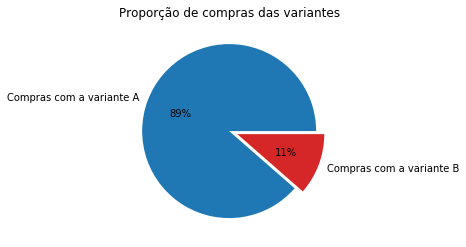

In [53]:
x = [compras_a, compras_b]
labels = ['Compras com a variante A', 'Compras com a variante B']
colors = ['tab:blue','tab:red']
explode = [0, 0.1]

fig, ax = plt.subplots()
ax.pie(x, labels = labels, colors = colors, autopct='%.0f%%', explode = explode)
ax.set_title('Proporção de compras das variantes')
plt.show()

In [55]:
# Probabilidade de conversão independente da variante recebida
df_vendas.compra.mean()

0.15607272727272728

In [56]:
# Dado que um indivíduo estava no grupo de controle, qual é a probabilidade de conversão?
df_vendas[df_vendas.variante == 'A'].compra.mean()

0.15206

In [57]:
# Dado que um indivíduo estava no grupo de tratamento, qual é a probabilidade de conversão?
df_vendas[df_vendas.variante == 'B'].compra.mean()

0.1962

A probabilidade de receber a nova página é de aproximadamente 10% e a probabilidade total de conversão é de 19%. Precisamos checar se temos evidências suficientes para dizer que o grupo de tratamento leva a um aumento das conversões.

## Configurando o Experimento

Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online?

Variante A: Mostra o número atual de comentários e avaliações de usuários

Variante B: Não mostra os comentários de usuários no site


Vamos definir as hipóteses como $p_{A}$ e $p_{B}$, que são as probabilidades de conversão para as variantes nova e antiga.

- H0: PB - PA = 0
- H1: PB - PA > 0

H0 nos diz que a diferença de probabilidade dos dois grupos é igual a zero.

H1 nos diz que a diferença de probabilidade dos dois grupos é maior do que zero.

### Pré-Processamento dos Dados

In [58]:
# Função para extrair ano e mês da data
def extrai_data(x):
    return x[:7]

In [59]:
# Extrai ano e mês da coluna de data
df_vendas['ano_mes'] = df_vendas['data'].apply(extrai_data)

In [60]:
# Visualiza
df_vendas.head()

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [61]:
# Vamos trabalhar apenas com os dados de Janeiro/2020 para reduzir o tempo de processamento
df_vendas_2020 = df_vendas[df_vendas['ano_mes'] == '2020-01']

In [62]:
# shape
df_vendas_2020.shape

(8821, 5)

### Criação do Baseline

Vamos criar um baseline (linha base) da taxa de conversão antes de executar o teste de hipótese. Assim, saberemos a taxa de conversão base e o aumento desejado em compras que gostaríamos de testar.

* A será o grupo de controle 
* B será o grupo de teste

In [63]:
# Geramos um dataframe
df_ab_data = df_vendas_2020[['variante', 'compra']]
df_ab_data.head()

,variante,compra
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [64]:
# Shape
df_ab_data.shape

(8821, 2)

In [66]:
# Altera o nome das colunas
df_ab_data.columns = ['grupo', 'conversao']
# Visualiza
df_ab_data.head()

,grupo,conversao
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [68]:
# Tabela pivot para o sumário dos dados
df_ab_sumario = df_ab_data.pivot_table(values = 'conversao', index = 'grupo', aggfunc = np.sum)
# Visualiza os dados
df_ab_sumario.head()

,conversao
grupo,
A,587.0
B,981.0


In [69]:
# Sumário com total 
df_ab_sumario['total'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo', aggfunc = lambda x: len(x))

In [70]:
# Sumário com taxa
df_ab_sumario['taxa'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo')

In [71]:
# Visualiza os dados
df_ab_sumario.head()

,conversao,total,taxa
grupo,,,
A,587.0,3821,0.153625
B,981.0,5000,0.196200


In [72]:
# Obtemos os valores da variante A
conversao_A = df_ab_sumario['conversao'][0]
total_A = df_ab_sumario['total'][0]
taxa_A = df_ab_sumario['taxa'][0]

In [73]:
# Imprime os valores de A
print(conversao_A)
print(total_A)
print(taxa_A)

587.0
3821
0.15362470557445695


In [74]:
# Obtemos os valores da variante B
conversao_B = df_ab_sumario['conversao'][1]
total_B = df_ab_sumario['total'][1]
taxa_B = df_ab_sumario['taxa'][1]

In [75]:
# Imprime os valores de B
print(conversao_B)
print(total_B)
print(taxa_B)

981.0
5000
0.1962


Taxa de conversão da linha de base (Baseline conversion rate).

Igual a $p$ no contexto de uma distribuição binomial e $p$ é a probabilidade de sucesso.

In [76]:
# Taxa de conversão da linha de base.
conversao_base = taxa_A
conversao_base

0.15362470557445695

Efeito mínimo detectável (Minimum Detectable Effect).

Às vezes referido como nível de significância prática.

In [77]:
# Efeito mínimo detectável
efeito_minimo = taxa_B - taxa_A
efeito_minimo

0.04257529442554306

## Tarefa 2 - Execução do Teste de Hipóteses

Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.

Poder estatístico ou sensibilidade.

Igual a 1 - $\beta$. 

Normalmente 80% é usado para a maioria das análises. É a probabilidade de rejeitar a hipótese nula quando a hipótese nula é de fato falsa.

Parâmetros que usaremos para executar o teste:

1- Alfa (Nível de significância) $\alpha$: normalmente 5%; probabilidade de rejeitar a hipótese nula quando a hipótese nula for verdadeira

2- Beta $\beta$: probabilidade de aceitar a hipótese nula quando a hipótese nula é realmente falsa.

In [78]:
# Parâmetros que usaremos para executar o teste
alfa = 0.05
beta = 0.2

In [79]:
# Tamanho da amostra
n = 50000

Podemos supor que a distribuição de nosso grupo de controle é binomial porque os dados são uma série de tentativas de Bernoulli, em que cada tentativa tem apenas dois resultados possíveis (comprar ou não comprar).
 
 Para o teste usaremos a função binom() do SciPy:

In [80]:
# Teste Binomial (usando padrão de 5% para o nível de significância)
teste_binom = scs.binom(n, p = conversao_base)

In [81]:
# Teste Binomial com o efeito mínimo (no nosso exemplo 0.04 para o nível de significância)
teste_binom_mde = scs.binom(n, p = conversao_base + efeito_minimo)

<BarContainer object of 50001 artists>

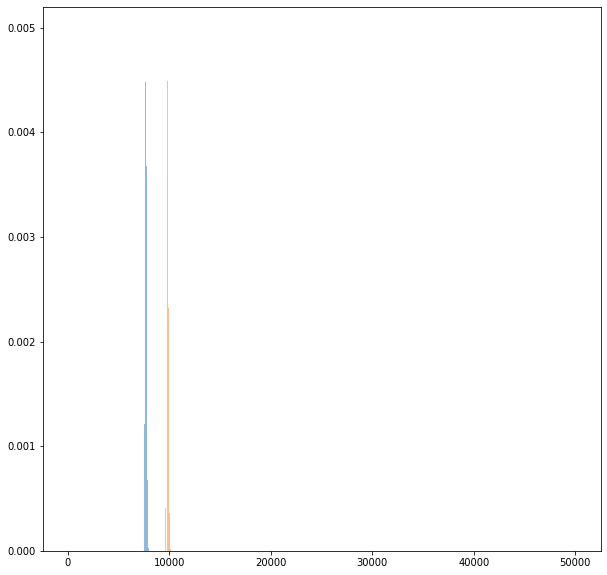

In [82]:
# Plot

# Área de plotagem
fig, ax = plt.subplots(figsize = (10, 10))

# Definimos diversos valores para x
x = np.linspace(0,int(n), int(n) + 1)

# Plotamos os resultados com a pmf e alfa de 0.5
ax.bar(x, teste_binom.pmf(x), alpha = 0.5)
ax.bar(x, teste_binom_mde.pmf(x), alpha = 0.5)

## Tarefa 3 - Plot da Distribuição

Criamos o Plot da distribuição da diferença entre as duas amostras e comparamos os resultados.

Podemos comparar os dois grupos traçando a distribuição do grupo de controle e calculando a probabilidade de obter o resultado de nosso grupo de teste.

Text(0, 0.5, 'Probabilidade')

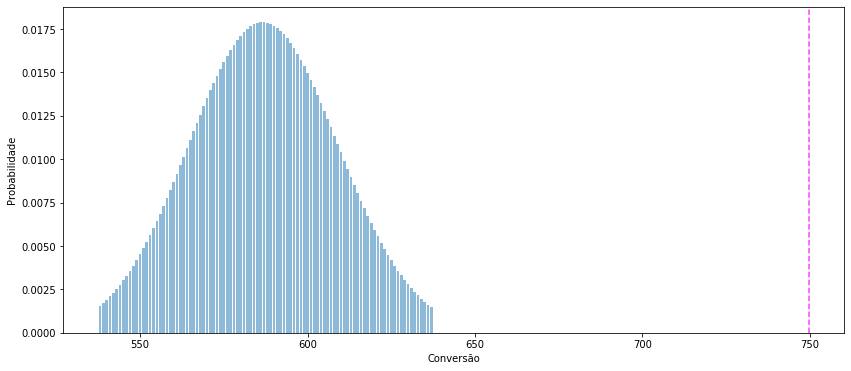

In [83]:
# Plot da distribuição do grupo A (controle)

# Área de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Teste de A
x = np.linspace(conversao_A - 49, conversao_A + 50, 100)
y = scs.binom(total_A, taxa_A).pmf(x)

# Cria a barra vertical
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = taxa_B * total_A, c = 'magenta', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Text(0, 0.5, 'Probabilidade')

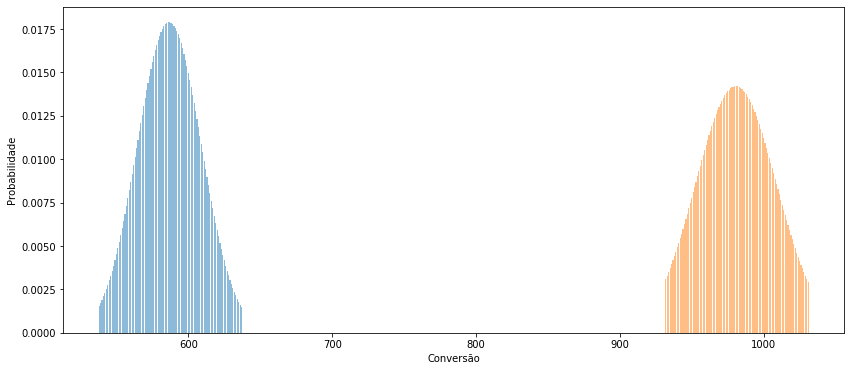

In [84]:
# Plot da distribuição dos 2 grupos

# Área de plotagem 
fig, ax = plt.subplots(figsize = (14,6))

# Gráfico de A
xA = np.linspace(conversao_A - 49, conversao_A + 50, 100)
yA = scs.binom(total_A, taxa_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B
xB = np.linspace(conversao_B - 49, conversao_B + 50, 100)
yB = scs.binom(total_B, taxa_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Podemos ver que o grupo de teste converteu mais usuários do que o grupo de controle. Também podemos ver que o pico dos resultados do grupo de teste é inferior ao do grupo de controle. 

Mas como interpretamos a diferença no pico da probabilidade? 

Devemos nos concentrar, em vez disso, na taxa de conversão para que tenhamos uma comparação de termos equivalentes. Para calcular isso, precisamos padronizar os dados e comparar a probabilidade de sucesso, p, para cada grupo.

In [85]:
# Ajusta o nome das variáveis

# Probabilidades (taxas de conversão)
p_A = taxa_A
p_B = taxa_B

# Número de conversões
N_A = 3821
N_B = 5000

In [86]:
# Erro padrão (standard error) para a média de ambos os grupos
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

In [87]:
# Print
print(SE_A)
print(SE_B)

0.005833423432971666
0.0056161474339621814


Text(0, 0.5, 'PDF - Probability Density Function')

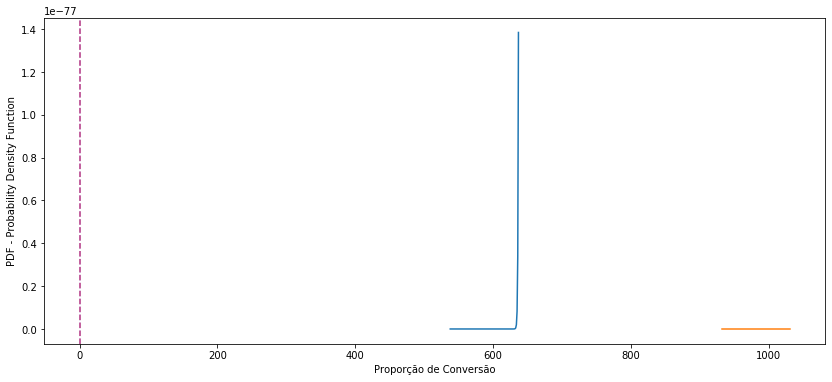

In [88]:
# Plot das distribuições das hipóteses nula e alternativa

# Área de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Dados para a variável aleatória
x = np.linspace(0, p_B - p_A, 100)

# Distribuição de A
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x = p_A, c = 'blue', alpha = 0.5, linestyle = '--')

# Distribuição de B
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x = p_B, c = 'red', alpha = 0.5, linestyle = '--')

# Labels
plt.xlabel('Proporção de Conversão')
plt.ylabel('PDF - Probability Density Function')

As linhas contínuas representam a taxa de conversão média para cada grupo. A distância entre a linha azul e a linha vermelha é igual à diferença média entre o grupo de controle e teste. 

**Variância da Soma**

Lembre-se de que a hipótese nula afirma que a diferença de probabilidade entre os dois grupos é zero. Portanto, a média para essa distribuição normal será zero. A outra propriedade de que precisaremos para a distribuição normal é o desvio padrão ou a variância.

Observação: a variância é o desvio padrão ao quadrado. A variância da diferença dependerá das variâncias da probabilidade para ambos os grupos.

Leia o manual em pdf **Variância da Soma** para compreender uma importante propriedade da variância.

### Verificando a Hipótese Nula e a Hipótese Alternativa



**A hipótese nula é a posição de que a mudança no design feito para o grupo de teste resultaria em nenhuma mudança na taxa de conversão.**

**A hipótese alternativa é a posição oposta de que a mudança no design do grupo de teste resultaria em uma melhoria (ou redução) na taxa de conversão.**

A hipótese nula será uma distribuição normal com uma média de zero e um desvio padrão igual ao erro padrão agrupado.

A hipótese alternativa tem o mesmo desvio padrão que a hipótese nula, mas a média estará localizada na diferença na taxa de conversão, d_hat. Isso faz sentido porque podemos calcular a diferença nas taxas de conversão diretamente dos dados, mas a distribuição normal representa possíveis valores que nosso experimento poderia ter nos dado.

Fórmula para o cálculo de z:

$$ z = \frac{(\bar{x_1}-\bar{x_2})-D_0}{\sqrt{\sigma_1^{2}/n_1+\sigma_{2}^{2}/n_2}} $$

$$ z = \frac{(\hat{p_1}-\hat{p_2})-0}{\sqrt{\hat{p}\hat{q}(\frac{1}{n_1}+\frac{1}{n_2})}}$$

In [89]:
# Calculando a probabilidade agrupada
prob_agrupada = (p_A * N_A + p_B * N_B) / (N_A + N_B)
# Calculando z
z = (p_B - p_A) / (prob_agrupada * (1 - prob_agrupada) * (1 / N_A + 1 / N_B))**0.5
z

5.1827257006909795

In [90]:
# Verificamos se z é maior que 1.64 (nível de significância de 0.05)
z > 1.64

True

### Plot da Distribuição de Probabilidade

Criaremos uma série de funções auxiliares para o plot das distribuições de probabilidade. Leia atentamente todos os comentários.

In [91]:
# Função que retorna a probabilidade agrupada para 2 amostras
def prob_agrupada_func(N_A, N_B, X_A, X_B):
    return (X_A + X_B) / (N_A + N_B)

In [92]:
# Função que retorna o erro padrão agrupado para 2 amostras
def erro_padrao_agrupado_func(N_A, N_B, X_A, X_B):
    p_hat = prob_agrupada_func(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

In [93]:
# Retorna o valor z para um determinado nível de significância
def z_val(sig_level = 0.05, two_tailed = True):
    
    # Gera distribuição para o valor z
    z_dist = scs.norm()
    
    # Verifica se devemos checar as duas caudas
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    # Valor de z
    z = z_dist.ppf(area)

    return z

In [94]:
# Calcula o intervalo de confiança
def confidence_interval(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    
    # Calcula o valor de z
    z = z_val(sig_level)

    # Limites à esquerda e direita
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

In [95]:
# Função que calcula o intervalo de confiança de duas caudas 
def plot_CI(ax, 
            mu, 
            s, 
            sig_level = 0.05, 
            color = 'grey'):

    # Calcula o intervalo de confiança
    left, right = confidence_interval(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    # Inclui o intervalo no gráfico
    ax.axvline(left, c = color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [96]:
# Função para o plot de uma distribuição normal
def plot_norm_dist(ax, 
                   mu, 
                   std, 
                   with_CI = False, 
                   sig_level = 0.05, 
                   label = None):

    # Gera valores para a variável aleatória x
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    
    # Cria a distribuição normal
    y = scs.norm(mu, std).pdf(x)
    
    # Plot
    ax.plot(x, y, label = label)

    # Se tivermos intervalo de confiança, incluímos no plot
    if with_CI:
        plot_CI(ax, mu, std, sig_level = sig_level)

Função para o plot da distribuição de hipótese nula onde, se não houver mudança real, a distribuição das diferenças entre os grupos de teste e controle será normalmente distribuída.

In [97]:
# Função para o plot da distribuição da H0
def plot_H0(ax, stderr):
    plot_norm_dist(ax, 0, stderr, label = "H0 - Hipótese Nula")
    plot_CI(ax, mu = 0, s = stderr, sig_level = 0.05)

Função para o plot da distribuição de hipótese alternativa onde, se houver uma mudança real, a distribuição das diferenças entre o teste e os grupos de controle será normalmente distribuída e centralizada em torno de d_hat

In [98]:
# Função para o plot da distribuição da H1
def plot_H1(ax, stderr, d_hat):
    plot_norm_dist(ax, d_hat, stderr, label = "H1 - Hipótese Alternativa")

In [99]:
# Função que preenche entre o limite de significância superior e a distribuição para hipótese alternativa
def show_area(ax, d_hat, stderr, sig_level):

    # Intervalo de confiança
    left, right = confidence_interval(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # Valores para x
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'controle')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'teste')

    # Se o tipo da área for igual a power
    # Preenchemos entre o limite de significância superior e a distribuição para hipótese alternativa
    ax.fill_between(x, 0, alternative.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format(1 - alternative.cdf(right)), 
                fontsize = 12, ha = 'right', color = 'k')

In [100]:
# Função que retorna um objeto de distribuição dependendo do tipo de grupo
def ab_dist(stderr, d_hat = 0, group_type = 'controle'):

    # Verifica o tipo de grupo
    if group_type == 'controle':
        sample_mean = 0
    elif group_type == 'teste':
        sample_mean = d_hat

    # Cria uma distribuição normal que depende da média e do desvio padrão
    dist = scs.norm(sample_mean, stderr)
    return dist

In [101]:
# Função que retorna o valor p
def p_val(N_A, N_B, p_A, p_B):
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [102]:
# Função para o plot da análise do Teste A/B
def abplot_func(N_A, 
                N_B, 
                bcr, 
                d_hat, 
                sig_level = 0.05, 
                show_p_value = False,
                show_legend = True):
   
    # Define a área de plotagem
    fig, ax = plt.subplots(figsize = (14, 8))

    # Define parâmetros para encontrar o erro padrão agrupado
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = erro_padrao_agrupado_func(N_A, N_B, X_A, X_B)

    # Plot da distribuição da hipótese nula e alternativa
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)

    # Definir a extensão da área do plot
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # Ajustamos o gráfico e preenchemos a área interior
    show_area(ax, d_hat, stderr, sig_level)

    # Mostramos valores-p com base nas distribuições para os dois grupos
    if show_p_value:
        null = ab_dist(stderr, 'controle')
        p_value = p_val(N_A, N_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), 'Valor-p = {0:.4f}'.format(p_value), fontsize = 14, ha = 'left')

    # Mostra a legenda
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

Agora que entendemos a derivação do erro padrão combinado, podemos apenas plotar diretamente as hipóteses nula e alternativa para experimentos futuros. Tudo que precisamos é executar a célula abaixo.

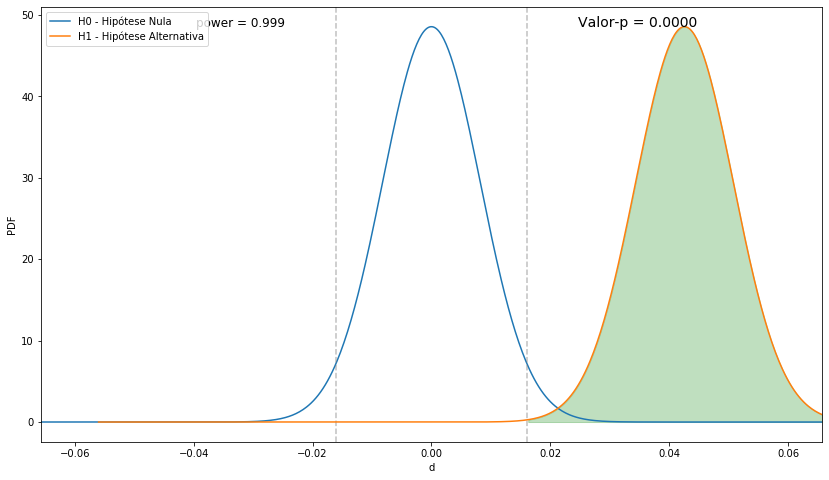

In [104]:
# Definimos os parâmetros e executamos a função
n = N_A + N_B
conversao_base = p_A  
d_hat = p_B - p_A
abplot_func(N_A, N_B, conversao_base, d_hat, show_p_value = True)

Visualmente, o gráfico para as hipóteses nula e alternativa é muito semelhante aos outros gráficos acima. Felizmente, as duas curvas têm formato idêntico, portanto, podemos apenas comparar a distância entre as médias das duas distribuições. Podemos ver que a curva de hipótese alternativa sugere que o grupo de teste tem uma taxa de conversão maior do que o grupo de controle. Este gráfico também pode ser usado para determinar diretamente o poder estatístico.

## Tarefa 4 - Calculando o Poder Estatístico

Poder Estatístico e Nível de Significância

É mais fácil definir o poder estatístico e o nível de significância mostrando primeiro como eles são representados no gráfico da hipótese nula e alternativa. Podemos retornar uma visualização do poder estatístico adicionando o parâmetro show_power = True

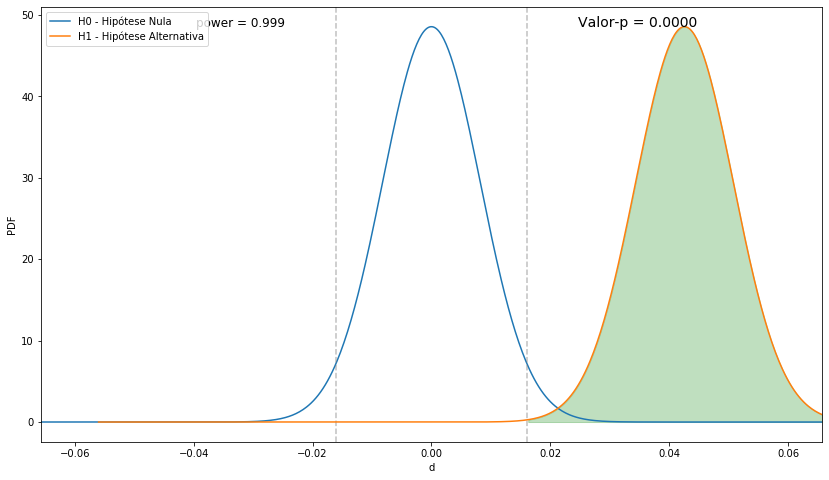

In [105]:
# Executa a função
abplot_func(N_A, N_B, conversao_base, d_hat, show_p_value = True)

A área sombreada em verde representa o poder estatístico e o valor calculado para o poder também é exibido no gráfico. As linhas tracejadas em cinza no gráfico acima representam o intervalo de confiança (95% para o gráfico acima) para a hipótese nula. O poder estatístico é calculado encontrando a área sob a distribuição de hipótese alternativa e fora do intervalo de confiança da hipótese nula.

Depois de executar nosso experimento, obtemos uma taxa de conversão resultante para ambos os grupos. Se calcularmos a diferença entre as taxas de conversão, acabamos com um resultado, a diferença ou o efeito da mudança de design da página web, não mostrando as avaliações de usuários. Nossa tarefa é determinar de qual população esse resultado veio, a hipótese nula ou a hipótese alternativa.

A área sob a curva da hipótese alternativa é igual a 1. Se o design alternativo (sem avaliações) for realmente melhor, o poder é a probabilidade de aceitarmos a hipótese alternativa e rejeitarmos a hipótese nula e é igual à área sombreada em verde (verdadeiro positivo). A área oposta sob a curva alternativa é a probabilidade de não rejeitarmos a hipótese nula e rejeitarmos a hipótese alternativa (falso negativo). Isso é conhecido como beta no teste A/B ou teste de hipótese e é mostrado abaixo.

Se a hipótese nula for verdadeira e realmente não houver diferença entre os grupos de controle e teste, o nível de significância é a probabilidade de rejeitarmos a hipótese nula e aceitarmos a hipótese alternativa (falso positivo). Um falso positivo é quando concluímos erroneamente que o novo design é melhor. Este valor é baixo porque queremos limitar essa probabilidade.

Muitas vezes, um problema será fornecido com um nível de confiança desejado em vez do nível de significância. Um nível de confiança típico de 95% para um teste A / B corresponde a um nível de significância de 0,05.

Os experimentos são normalmente configurados para uma potência mínima desejada de 80%. Se nosso novo design for realmente melhor, queremos que nosso experimento mostre que há pelo menos 80% de probabilidade de que esse seja o caso. Sabemos que, se aumentarmos o tamanho da amostra para cada grupo, diminuiremos a variância combinada para nossa hipótese nula e alternativa. Isso tornará nossas distribuições muito mais estreitas e pode aumentar o poder estatístico. Vamos dar uma olhada em como o tamanho da amostra afetará diretamente nossos resultados.

## Tarefa 5 - Influência do Tamanho da Amostra no Teste A/B

Nossas curvas para a hipótese nula e alternativa tornaram-se mais estreitas e mais da área sob a curva alternativa está localizada à direita da linha tracejada cinza. O resultado para potência é maior que 0,80 e atende a nossa referência de potência estatística. Agora podemos dizer que nossos resultados são estatisticamente significativos.

O próximo problema que devemos encontrar é determinar o tamanho mínimo da amostra de que precisaremos para o experimento. E isso é útil saber porque está diretamente relacionado à rapidez com que podemos concluir os experimentos e fornecer resultados estatisticamente significativos para a área de negócio.

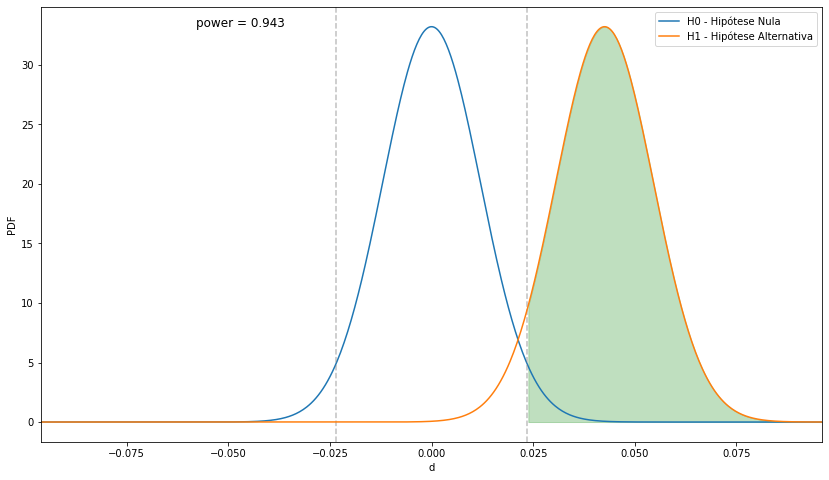

In [106]:
# Executa a função
abplot_func(2000, 2000, conversao_base, d_hat)

Temos a taxa de conversão de linha de base e o efeito mínimo detectável, que é a diferença mínima entre o controle e o grupo de teste que a equipe de negócio determinará para valer a pena o investimento de fazer a mudança de design em primeiro lugar.

In [107]:
# Função para incluir o valor z no plot
def zplot(area = 0.95, two_tailed = True, align_right = False):

    # Cria a área de plotagem
    fig = plt.figure(figsize = (12, 6))
    ax = fig.subplots()
    
    # Cria a distribuição normal
    norm = scs.norm()
    
    # Cria os pontos de dados para o plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # Código para preencher áreas para testes bidirecionais
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
        ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')

        ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = (x > left) & (x < right))
        
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "left")
    
    # Para testes de uma cauda
    else:
        # Alinhamento à direita
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "right")
        
        # Alinhamento à esquerda
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "left")

    # Incluímos texto no plot
    plt.text(0, 0.1, "Área Sombreada = {0:.3f}".format(area), fontsize = 12, ha = 'center')
    
    # Labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

In [108]:
# Print do valor z
print(z)
print(z_val(sig_level = 0.05, two_tailed = False))
print(z > z_val(sig_level = 0.05, two_tailed = False))

5.1827257006909795
1.6448536269514722
True


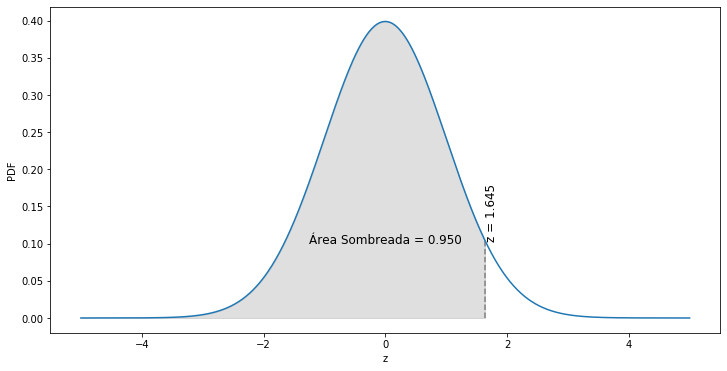

In [109]:
# Plot de z
zplot(area = 0.95, two_tailed = False, align_right = False)

In [110]:
# Calculamos os valores de z alfa e beta
sig_level = 0.05
beta = 0.2
k = N_A/N_B
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(1-beta)
Z_alpha = standard_norm.ppf(1-sig_level)
print(Z_beta)
print(Z_alpha)

0.8416212335729143
1.6448536269514722


Vamos calcular o tamanho mínimo necessário para a amostra.

In [111]:
# Função para encontrar o tamanho mínimo da amostra
def calcula_tamanho_min_amostra(N_A, 
                                N_B, 
                                p_A, 
                                p_B, 
                                power = 0.8, 
                                sig_level = 0.05, 
                                two_sided = False):
   
    k = N_A/N_B
    
    # Distribuição normal para determinar os valores z
    standard_norm = scs.norm(0, 1)

    # Encontramos o valor de z para o poder estatístico
    Z_beta = standard_norm.ppf(power)
    
    # Encontramos z alfa
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # Probabilidade agrupada
    pooled_prob = (p_A + p_B) / 2

    # Tamanho mínimo da amostra
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / efeito_minimo**2)    

    return min_N

In [112]:
# Calculamos o tamanho mínimo da amostra com two_sided = True
calcula_tamanho_min_amostra(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)

1249.8068972849476

In [113]:
# Calculamos o tamanho mínimo da amostra com two_sided = False
calcula_tamanho_min_amostra(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = False)

984.4720435225323

Agora vamos calcular o tamanho mínimo da amostra considerando nosso baseline.

In [114]:
conversao_base + efeito_minimo

0.1962

In [115]:
# Calcula a probabilidade agrupada
probabilidade_agrupada = (conversao_base + conversao_base + efeito_minimo) / 2
probabilidade_agrupada

0.1749123527872285

In [116]:
# Soma de z alfa e beta
Z_beta + Z_alpha

2.4864748605243863

In [117]:
# Tamanho mínimo da amostra para o baseline
min_N = (2 * probabilidade_agrupada * (1 - probabilidade_agrupada) * (Z_beta + Z_alpha)**2 / efeito_minimo**2)
min_N

984.4720435225323

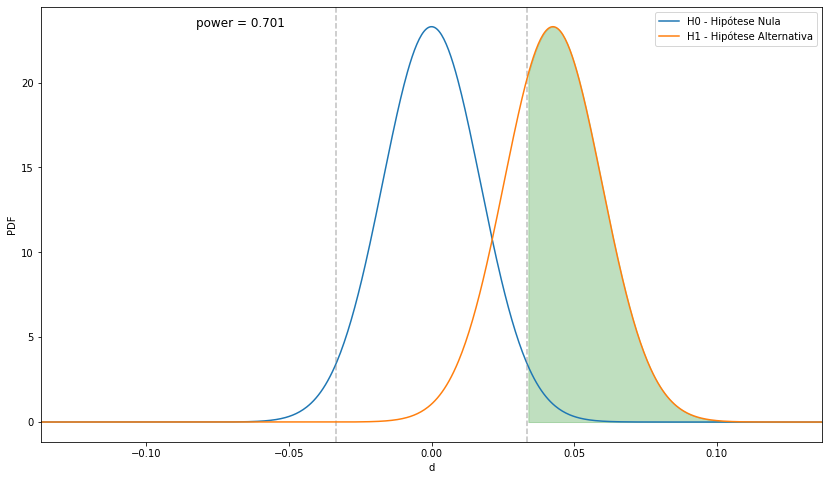

In [118]:
# Executa a função para 984 amostras
abplot_func(N_A = 984, 
            N_B = 984, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

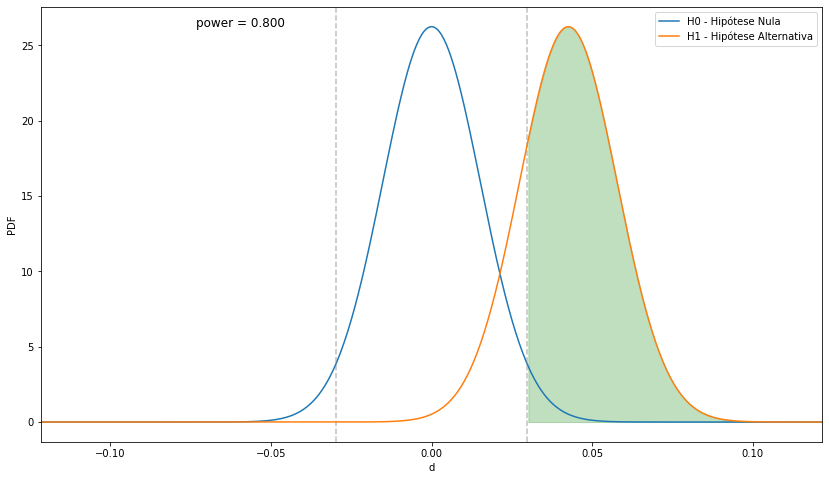

In [119]:
# Executa a função para 1249 amostras
abplot_func(N_A = 1249, 
            N_B = 1249, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

## Conclusão e Considerações Finais

Para o nosso exemplo, com 1249 amostras podemos afirmar que sim, remover as avaliações de usuários da página aumenta a taxa de conversão.